<a href="https://colab.research.google.com/github/gisellafrlnd/idx-stock-topsis-analysis/blob/main/Indonesia's_Stock_Analysis_Gisella_Firlianda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Pemilihan Saham Indonesia dengan Metode TOPSIS & Entropy Weighting

**Author:** Gisella Firlianda
**Dataset:** Saham Indonesia (Kaggle) — 956 saham, 107 kolom

---

## Problem Statement

Banyak investor pemula memilih saham hanya berdasarkan **satu metrik** (misalnya PE Ratio rendah = murah = beli).
Padahal, keputusan investasi yang baik seharusnya mempertimbangkan **banyak faktor sekaligus**.

## Metode
- **Entropy Method** — untuk menentukan bobot kriteria secara objektif berdasarkan variasi data
- **TOPSIS** (Technique for Order of Preference by Similarity to Ideal Solution) — untuk meranking saham berdasarkan multi-kriteria

## Kriteria (6 Kriteria, 4 Dimensi)

| No | Kriteria | Dimensi | Atribut | Alasan |
|----|----------|---------|---------|--------|
| C1 | PE Ratio | Value | Cost | Harga relatif terhadap laba |
| C2 | PB Ratio | Value | Cost | Harga relatif terhadap nilai buku |
| C3 | ROE | Quality | Benefit | Efisiensi pengelolaan modal |
| C4 | Profit Margin | Quality | Benefit | Efisiensi operasional |
| C5 | D/E Ratio | Safety | Cost | Tingkat risiko utang |
| C6 | Dividend Yield | Income | Benefit | Pendapatan pasif investor |

---
## Step 0: Setup & Upload Data

In [73]:
# Install & import libraries
!pip install seaborn openpyxl -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from google.colab import files

# Style settings
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

print('Libraries loaded!')

Libraries loaded!


In [74]:
# Upload file
print('📁 Upload file saham_indonesia.xlsx')
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df_raw = pd.read_excel(filename)
print(f'\nData loaded: {df_raw.shape[0]} baris, {df_raw.shape[1]} kolom')

📁 Upload file saham_indonesia.xlsx


Saving saham_indonesia.xlsx to saham_indonesia (3).xlsx

Data loaded: 956 baris, 107 kolom


---
## Step 1: Data Cleaning & Exploration

Dataset ini punya banyak kolom dengan format string (mengandung T, B, M, K, %) yang harus dikonversi ke numerik.

In [75]:
# 1a. Bersihkan nama kolom (hapus non-breaking space)
df_raw.columns = df_raw.columns.str.replace('\xa0', ' ').str.strip()

# Lihat kolom-kolom yang tersedia
print('Semua kolom dalam dataset:')
for i, col in enumerate(df_raw.columns):
    print(f'  {i:3d}. {col}')

Semua kolom dalam dataset:
    0. Unnamed: 0
    1. code
    2. market cap_current
    3. enterprise value_current
    4. trailing p/e_current
    5. forward p/e_current
    6. peg ratio (5yr expected)_current
    7. price/sales_current
    8. price/book_current
    9. enterprise value/revenue_current
   10. enterprise value/ebitda_current
   11. market cap_-1
   12. enterprise value_-1
   13. trailing p/e_-1
   14. forward p/e_-1
   15. peg ratio (5yr expected)_-1
   16. price/sales_-1
   17. price/book_-1
   18. enterprise value/revenue_-1
   19. enterprise value/ebitda_-1
   20. market cap_-2
   21. enterprise value_-2
   22. trailing p/e_-2
   23. forward p/e_-2
   24. peg ratio (5yr expected)_-2
   25. price/sales_-2
   26. price/book_-2
   27. enterprise value/revenue_-2
   28. enterprise value/ebitda_-2
   29. market cap_-3
   30. enterprise value_-3
   31. trailing p/e_-3
   32. forward p/e_-3
   33. peg ratio (5yr expected)_-3
   34. price/sales_-3
   35. price/book_-3
   36. 

In [76]:
# 1b. Fungsi parsing untuk mengkonversi string ke numerik
# Contoh: '1,109.46T' -> 1109460000000000, '51.93%' -> 51.93, '--' -> NaN

def parse_value(val):
    """Konversi string keuangan ke float."""
    if isinstance(val, (int, float)):
        return val
    if not isinstance(val, str):
        return np.nan

    val = val.strip().replace(',', '')

    # Handle missing values
    if val in ('--', 'N/A', '', 'nan'):
        return np.nan

    # Handle percentages: '51.93%' -> 51.93
    if val.endswith('%'):
        try:
            return float(val[:-1])
        except ValueError:
            return np.nan

    # Handle suffixes: T (Triliun), B (Miliar), M (Juta), K (Ribu)
    suffixes = {'T': 1e12, 'B': 1e9, 'M': 1e6, 'K': 1e3}
    for suffix, multiplier in suffixes.items():
        if val.endswith(suffix):
            try:
                return float(val[:-1]) * multiplier
            except ValueError:
                return np.nan

    # Handle plain numbers
    try:
        return float(val)
    except ValueError:
        return np.nan

# Test fungsi parsing
test_cases = ['1,109.46T', '51.93%', '--', '19.74', '214.51M', '0.34']
print('Test parsing:')
for tc in test_cases:
    print(f'  "{tc}" -> {parse_value(tc)}')

Test parsing:
  "1,109.46T" -> 1109460000000000.0
  "51.93%" -> 51.93
  "--" -> nan
  "19.74" -> 19.74
  "214.51M" -> 214510000.0
  "0.34" -> 0.34


In [77]:
# 1c. Mapping kolom yang kita butuhkan
# Dari 107 kolom, kita hanya butuh 6 kriteria + kode saham

column_mapping = {
    'code': 'code',
    'pe_ratio': 'trailing p/e_current',           # C1 - Value (Cost)
    'pb_ratio': 'price/book_current',              # C2 - Value (Cost)
    'roe': 'return_on_equity (ttm)',               # C3 - Quality (Benefit)
    'profit_margin': 'profit_margin',              # C4 - Quality (Benefit)
    'debt_equity': 'total_debt/equity (mrq)',      # C5 - Safety (Cost)
    'div_yield': 'forward_annual_dividend_yield 4' # C6 - Income (Benefit)
}

# Buat dataframe bersih
df_clean = pd.DataFrame()
df_clean['code'] = df_raw['code']

for new_name, old_name in column_mapping.items():
    if new_name != 'code':
        df_clean[new_name] = df_raw[old_name].apply(parse_value)

print(f'Data setelah parsing:')
print(f'   Total saham: {len(df_clean)}')
print(f'\nNon-null count per kolom:')
print(df_clean.notna().sum())
print(f'\nMissing values per kolom:')
print(df_clean.isna().sum())

Data setelah parsing:
   Total saham: 956

Non-null count per kolom:
code             956
pe_ratio         545
pb_ratio         592
roe              849
profit_margin    893
debt_equity      747
div_yield        354
dtype: int64

Missing values per kolom:
code               0
pe_ratio         411
pb_ratio         364
roe              107
profit_margin     63
debt_equity      209
div_yield        602
dtype: int64


In [78]:
# 1d. Lihat statistik deskriptif awal
print('Statistik Deskriptif (sebelum filtering):\n')
df_clean.describe().round(2)

Statistik Deskriptif (sebelum filtering):



,pe_ratio,pb_ratio,roe,profit_margin,debt_equity,div_yield
count,545.00,592.00,849.00,893.00,747.00,354.00
mean,49.46,5.56,2.66,16.62,120.43,4.63
std,110.71,35.01,31.20,454.13,1145.75,4.58
min,0.09,0.02,-465.96,-296.64,0.00,0.02
25%,7.11,0.54,-0.19,-0.07,8.54,1.54
50%,14.27,1.16,4.70,4.37,31.00,3.42
75%,35.29,2.62,11.94,12.67,73.36,6.36
max,962.50,688.53,167.22,13517.40,30362.41,42.03


In [79]:
# 1e. Filtering data - hanya saham dengan data LENGKAP di semua 6 kriteria
# + filter logis (PE > 0, PB > 0, D/E >= 0)

criteria_cols = ['pe_ratio', 'pb_ratio', 'roe', 'profit_margin', 'debt_equity', 'div_yield']

# Drop rows dengan missing values di kolom kriteria
df_filtered = df_clean.dropna(subset=criteria_cols).copy()
print(f'Setelah drop missing: {len(df_filtered)} saham (dari {len(df_clean)})')

# Filter logis
df_filtered = df_filtered[
    (df_filtered['pe_ratio'] > 0) &      # PE negatif = rugi, tidak valid
    (df_filtered['pb_ratio'] > 0) &       # PB negatif = ekuitas negatif
    (df_filtered['debt_equity'] >= 0) &   # D/E negatif = tidak valid
    (df_filtered['div_yield'] > 0) &      # Harus ada dividen
    (df_filtered['roe'] > 0) &            # ROE positif = perusahaan untung
    (df_filtered['profit_margin'] > 0)    # Margin positif = perusahaan untung
].copy()

print(f'Setelah filter logis: {len(df_filtered)} saham')

# Remove extreme outliers (PE > 200, PB > 50 biasanya anomali)
df_filtered = df_filtered[
    (df_filtered['pe_ratio'] <= 200) &
    (df_filtered['pb_ratio'] <= 50) &
    (df_filtered['debt_equity'] <= 500)
].copy()

print(f'Setelah remove outliers: {len(df_filtered)} saham')

# Reset index
df_filtered = df_filtered.reset_index(drop=True)

print(f'\nData siap analisis: {len(df_filtered)} saham × {len(criteria_cols)} kriteria')
print(f'\nPreview data:')
df_filtered[['code'] + criteria_cols].head(10)

Setelah drop missing: 237 saham (dari 956)
Setelah filter logis: 230 saham
Setelah remove outliers: 224 saham

Data siap analisis: 224 saham × 6 kriteria

Preview data:


,code,pe_ratio,pb_ratio,roe,profit_margin,debt_equity,div_yield
0,BBLD,16.07,0.75,3.60,11.81,377.20,3.10
1,BPFI,11.52,0.90,8.08,29.56,76.55,2.56
2,SPMA,7.76,0.34,4.03,3.52,24.23,4.69
3,LPGI,20.10,1.42,11.07,3.49,0.06,1.42
4,GDST,6.67,0.55,5.24,2.86,82.81,16.88
5,ASGR,5.15,0.58,11.73,7.61,1.30,8.12
6,PANS,26.26,0.73,7.57,31.17,3.13,11.80
7,BUDI,15.33,0.63,3.63,1.35,121.00,4.29
8,PTSN,8.55,0.59,7.35,6.81,17.32,3.43
9,KBLI,6.88,0.59,7.68,6.07,1.37,2.04


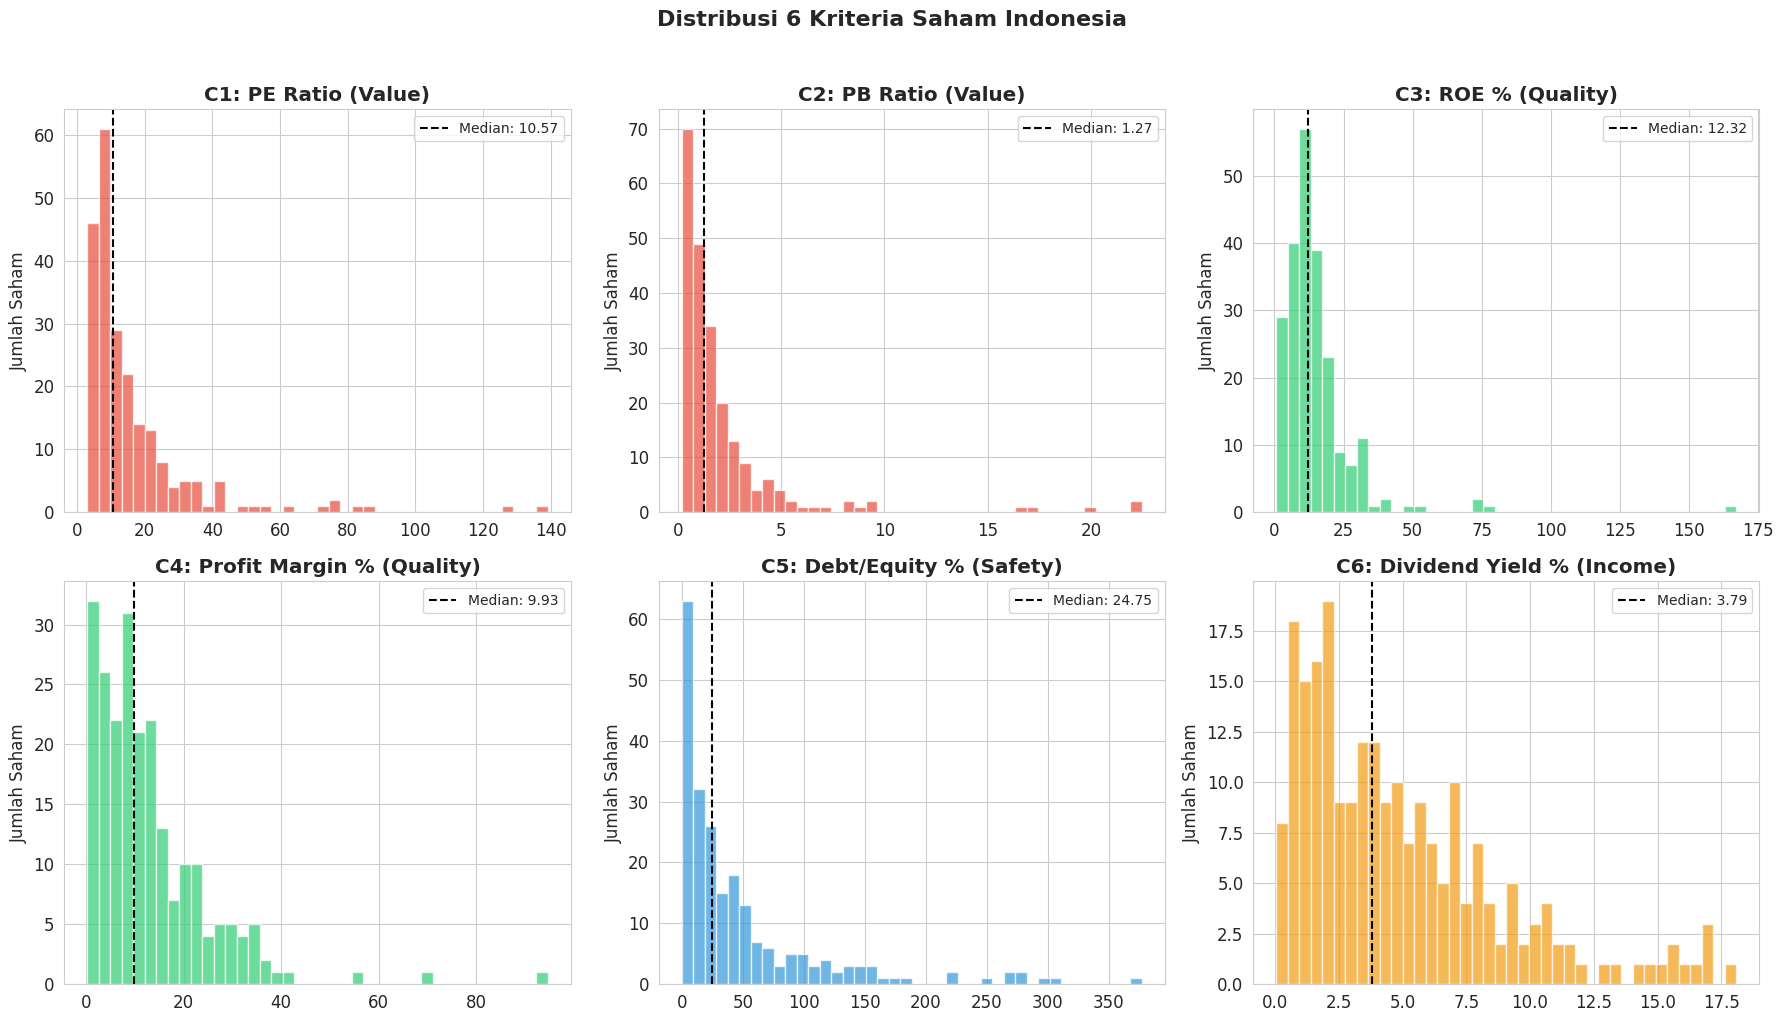

Saved: 01_distribusi_kriteria.png


In [80]:
# 1f. Visualisasi distribusi setiap kriteria

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribusi 6 Kriteria Saham Indonesia', fontsize=16, fontweight='bold', y=1.02)

titles = ['C1: PE Ratio (Value)', 'C2: PB Ratio (Value)', 'C3: ROE % (Quality)',
          'C4: Profit Margin % (Quality)', 'C5: Debt/Equity % (Safety)', 'C6: Dividend Yield % (Income)']
colors = ['#E74C3C', '#E74C3C', '#2ECC71', '#2ECC71', '#3498DB', '#F39C12']

for ax, col, title, color in zip(axes.flat, criteria_cols, titles, colors):
    data = df_filtered[col]
    ax.hist(data, bins=40, color=color, alpha=0.7, edgecolor='white')
    ax.axvline(data.median(), color='black', linestyle='--', linewidth=1.5, label=f'Median: {data.median():.2f}')
    ax.set_title(title, fontweight='bold')
    ax.legend(fontsize=10)
    ax.set_ylabel('Jumlah Saham')

plt.tight_layout()
plt.savefig('01_distribusi_kriteria.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: 01_distribusi_kriteria.png')

In [81]:
# 1g. Statistik deskriptif final
print('Statistik Deskriptif (data final):\n')
desc = df_filtered[criteria_cols].describe().round(2)
desc.loc['missing'] = df_filtered[criteria_cols].isna().sum()
desc

Statistik Deskriptif (data final):



,pe_ratio,pb_ratio,roe,profit_margin,debt_equity,div_yield
count,224.00,224.00,224.00,224.00,224.00,224.00
mean,16.55,2.15,15.11,12.91,48.38,4.88
std,18.01,3.17,15.16,11.79,64.75,3.95
min,3.09,0.20,0.66,0.29,0.00,0.05
25%,6.95,0.68,7.22,4.95,6.93,1.80
50%,10.57,1.27,12.32,9.93,24.74,3.79
75%,18.69,2.25,17.44,17.27,57.43,6.90
max,139.03,22.47,167.22,94.58,377.20,18.09
missing,0.00,0.00,0.00,0.00,0.00,0.00


---
## Step 2: Decision Matrix

Decision Matrix adalah tabel dasar TOPSIS — baris = alternatif (saham), kolom = kriteria.

In [82]:
# 2a. Buat Decision Matrix
alternatives = df_filtered['code'].values
X = df_filtered[criteria_cols].values.astype(float)

n_alternatives = X.shape[0]  # jumlah saham
n_criteria = X.shape[1]      # jumlah kriteria (6)

print(f'Decision Matrix: {n_alternatives} alternatif × {n_criteria} kriteria')
print(f'\nPreview Decision Matrix (10 saham pertama):\n')

dm = pd.DataFrame(X[:10], columns=criteria_cols, index=alternatives[:10])
dm.round(2)

Decision Matrix: 224 alternatif × 6 kriteria

Preview Decision Matrix (10 saham pertama):



,pe_ratio,pb_ratio,roe,profit_margin,debt_equity,div_yield
BBLD,16.07,0.75,3.60,11.81,377.20,3.10
BPFI,11.52,0.90,8.08,29.56,76.55,2.56
SPMA,7.76,0.34,4.03,3.52,24.23,4.69
LPGI,20.10,1.42,11.07,3.49,0.06,1.42
GDST,6.67,0.55,5.24,2.86,82.81,16.88
ASGR,5.15,0.58,11.73,7.61,1.30,8.12
PANS,26.26,0.73,7.57,31.17,3.13,11.80
BUDI,15.33,0.63,3.63,1.35,121.00,4.29
PTSN,8.55,0.59,7.35,6.81,17.32,3.43
KBLI,6.88,0.59,7.68,6.07,1.37,2.04


In [83]:
# 2b. Definisi atribut: Benefit (+) atau Cost (-)
# Cost = semakin kecil semakin baik
# Benefit = semakin besar semakin baik

criteria_types = ['cost', 'cost', 'benefit', 'benefit', 'cost', 'benefit']
# C1 PE     = Cost (makin rendah makin murah)
# C2 PB     = Cost (makin rendah makin murah)
# C3 ROE    = Benefit (makin tinggi makin efisien)
# C4 PM     = Benefit (makin tinggi makin profitable)
# C5 D/E    = Cost (makin rendah makin aman)
# C6 DY     = Benefit (makin tinggi makin banyak dividen)

print('Konfigurasi Kriteria:')
print('=' * 55)
for col, ctype in zip(criteria_cols, criteria_types):
    arrow = '↓ Lower is better' if ctype == 'cost' else '↑ Higher is better'
    print(f'  {col:20s} → {ctype.upper():7s} ({arrow})')

Konfigurasi Kriteria:
  pe_ratio             → COST    (↓ Lower is better)
  pb_ratio             → COST    (↓ Lower is better)
  roe                  → BENEFIT (↑ Higher is better)
  profit_margin        → BENEFIT (↑ Higher is better)
  debt_equity          → COST    (↓ Lower is better)
  div_yield            → BENEFIT (↑ Higher is better)


---
## Step 3: Entropy Method — Penentuan Bobot Objektif

Entropy Method menentukan bobot berdasarkan **variasi data**:
- Kriteria dengan data **lebih bervariasi** → bobot lebih besar (lebih berguna untuk membedakan)
- Kriteria dengan data **seragam** → bobot lebih kecil

### Langkah-langkah:
1. Normalisasi proporsi (p_ij)
2. Hitung Entropy (E_j)
3. Hitung Degree of Diversification (d_j = 1 - E_j)
4. Hitung Bobot (w_j = d_j / Σd_j)

In [84]:
# ============================================================
# STEP 3a: Normalisasi Proporsi
# ============================================================
# p_ij = x_ij / sum(x_ij) untuk setiap kolom j
# Catatan: semua nilai harus positif untuk entropy

# Pastikan tidak ada nilai 0 (tambah epsilon kecil)
X_positive = X.copy()
X_positive[X_positive <= 0] = 1e-10

# Hitung proporsi
col_sums = X_positive.sum(axis=0)  # jumlah per kolom
P = X_positive / col_sums          # p_ij = x_ij / Σx_ij

print('Step 3a: Normalisasi Proporsi (p_ij)')
print(f'   Sum per kolom: {col_sums.round(2)}')
print(f'\n   Verifikasi: sum setiap kolom P harus = 1.0')
print(f'   Sum P per kolom: {P.sum(axis=0).round(6)}')

print(f'\nPreview P (10 saham pertama):')
pd.DataFrame(P[:10], columns=criteria_cols, index=alternatives[:10]).round(6)

Step 3a: Normalisasi Proporsi (p_ij)
   Sum per kolom: [ 3706.58   481.54  3384.47  2891.19 10837.17  1093.75]

   Verifikasi: sum setiap kolom P harus = 1.0
   Sum P per kolom: [1. 1. 1. 1. 1. 1.]

Preview P (10 saham pertama):


,pe_ratio,pb_ratio,roe,profit_margin,debt_equity,div_yield
BBLD,0.004336,0.001558,0.001064,0.004085,0.034806,0.002834
BPFI,0.003108,0.001869,0.002387,0.010224,0.007064,0.002341
SPMA,0.002094,0.000706,0.001191,0.001217,0.002236,0.004288
LPGI,0.005423,0.002949,0.003271,0.001207,0.000006,0.001298
GDST,0.001800,0.001142,0.001548,0.000989,0.007641,0.015433
ASGR,0.001389,0.001204,0.003466,0.002632,0.000120,0.007424
PANS,0.007085,0.001516,0.002237,0.010781,0.000289,0.010789
BUDI,0.004136,0.001308,0.001073,0.000467,0.011165,0.003922
PTSN,0.002307,0.001225,0.002172,0.002355,0.001598,0.003136
KBLI,0.001856,0.001225,0.002269,0.002099,0.000126,0.001865


In [85]:
# ============================================================
# STEP 3b: Hitung Entropy (E_j)
# ============================================================
# E_j = -k * Σ(p_ij * ln(p_ij))
# dimana k = 1 / ln(n)

k = 1.0 / np.log(n_alternatives)
print(f'Step 3b: Hitung Entropy')
print(f'   k = 1/ln({n_alternatives}) = {k:.6f}')

# Hitung p * ln(p) — handle p=0 dengan mengset hasilnya ke 0
P_safe = np.where(P > 0, P, 1e-10)  # hindari log(0)
p_ln_p = P_safe * np.log(P_safe)

# Entropy per kriteria
E = -k * p_ln_p.sum(axis=0)

print(f'\nEntropy per kriteria:')
for col, e in zip(criteria_cols, E):
    bar = '█' * int(e * 50)
    print(f'   {col:20s}: E = {e:.6f}  {bar}')

print(f'\n💡 Interpretasi: E mendekati 1 = data seragam, E mendekati 0 = data bervariasi')

Step 3b: Hitung Entropy
   k = 1/ln(224) = 0.184787

Entropy per kriteria:
   pe_ratio            : E = 0.931507  ██████████████████████████████████████████████
   pb_ratio            : E = 0.894785  ████████████████████████████████████████████
   roe                 : E = 0.944009  ███████████████████████████████████████████████
   profit_margin       : E = 0.937461  ██████████████████████████████████████████████
   debt_equity         : E = 0.875838  ███████████████████████████████████████████
   div_yield           : E = 0.943826  ███████████████████████████████████████████████

💡 Interpretasi: E mendekati 1 = data seragam, E mendekati 0 = data bervariasi


In [86]:
# ============================================================
# STEP 3c: Degree of Diversification (d_j)
# ============================================================
# d_j = 1 - E_j
# Semakin besar d = semakin bervariasi = semakin penting

d = 1 - E

print(f'Step 3c: Degree of Diversification (d = 1 - E)')
print(f'\nHasil:')
for col, e_val, d_val in zip(criteria_cols, E, d):
    bar = '█' * int(d_val * 200)
    print(f'   {col:20s}: E = {e_val:.4f}, d = {d_val:.6f}  {bar}')

Step 3c: Degree of Diversification (d = 1 - E)

Hasil:
   pe_ratio            : E = 0.9315, d = 0.068493  █████████████
   pb_ratio            : E = 0.8948, d = 0.105215  █████████████████████
   roe                 : E = 0.9440, d = 0.055991  ███████████
   profit_margin       : E = 0.9375, d = 0.062539  ████████████
   debt_equity         : E = 0.8758, d = 0.124162  ████████████████████████
   div_yield           : E = 0.9438, d = 0.056174  ███████████


In [87]:
# ============================================================
# STEP 3d: Hitung Bobot (w_j)
# ============================================================
# w_j = d_j / Σd_j

weights = d / d.sum()

print(f'Step 3d: Bobot Entropy (w = d / Σd)')
print(f'   Σd = {d.sum():.6f}')
print(f'\n' + '=' * 60)
print(f'{"Kriteria":20s} | {"Dimensi":10s} | {"Bobot":10s} | {"Visual"}')
print(f'=' * 60)

dimensi = ['Value', 'Value', 'Quality', 'Quality', 'Safety', 'Income']
for col, w, dim in zip(criteria_cols, weights, dimensi):
    bar = '██' * int(w * 50)
    print(f'  {col:20s}| {dim:10s} | {w:8.4f}  | {bar} {w*100:.1f}%')

print(f'=' * 60)
print(f'  {"TOTAL":20s}|            | {weights.sum():8.4f}  |')
print(f'\nBobot ditentukan secara objektif oleh Entropy Method!')
print(f'\nKriteria dengan variasi data terbesar mendapat bobot terbesar.')

Step 3d: Bobot Entropy (w = d / Σd)
   Σd = 0.472574

Kriteria             | Dimensi    | Bobot      | Visual
  pe_ratio            | Value      |   0.1449  | ██████████████ 14.5%
  pb_ratio            | Value      |   0.2226  | ██████████████████████ 22.3%
  roe                 | Quality    |   0.1185  | ██████████ 11.8%
  profit_margin       | Quality    |   0.1323  | ████████████ 13.2%
  debt_equity         | Safety     |   0.2627  | ██████████████████████████ 26.3%
  div_yield           | Income     |   0.1189  | ██████████ 11.9%
  TOTAL               |            |   1.0000  |

Bobot ditentukan secara objektif oleh Entropy Method!

Kriteria dengan variasi data terbesar mendapat bobot terbesar.


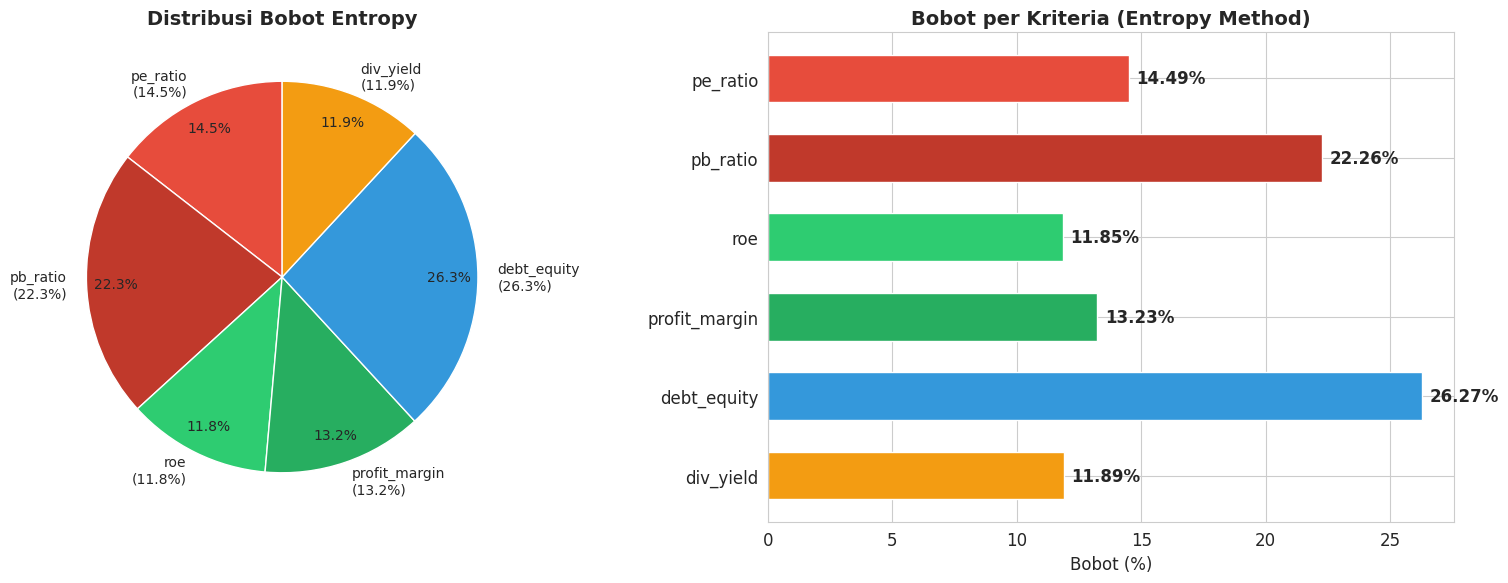

Saved: 02_bobot_entropy.png


In [88]:
# 3e. Visualisasi bobot Entropy

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
colors_pie = ['#E74C3C', '#C0392B', '#2ECC71', '#27AE60', '#3498DB', '#F39C12']
labels_pie = [f'{col}\n({w*100:.1f}%)' for col, w in zip(criteria_cols, weights)]
axes[0].pie(weights, labels=labels_pie, colors=colors_pie, autopct='%1.1f%%',
            startangle=90, pctdistance=0.85, textprops={'fontsize': 10})
axes[0].set_title('Distribusi Bobot Entropy', fontsize=14, fontweight='bold')

# Bar chart
bars = axes[1].barh(criteria_cols, weights * 100, color=colors_pie, edgecolor='white', height=0.6)
axes[1].set_xlabel('Bobot (%)', fontsize=12)
axes[1].set_title('Bobot per Kriteria (Entropy Method)', fontsize=14, fontweight='bold')
for bar, w in zip(bars, weights):
    axes[1].text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                f'{w*100:.2f}%', va='center', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('02_bobot_entropy.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: 02_bobot_entropy.png')

---
## Step 4: TOPSIS — Ranking Saham

### Langkah TOPSIS:
1. Normalisasi Decision Matrix (vector normalization)
2. Weighted Normalized Decision Matrix
3. Tentukan Solusi Ideal Positif (A+) dan Negatif (A-)
4. Hitung Jarak ke A+ dan A-
5. Hitung Skor Preferensi (Closeness Coefficient)
6. Ranking

In [89]:
# ============================================================
# STEP 4a: Normalisasi Decision Matrix (Vector Normalization)
# ============================================================
# r_ij = x_ij / sqrt(Σ(x_ij²))

# Hitung denominator: akar dari jumlah kuadrat per kolom
sum_squares = np.sqrt((X ** 2).sum(axis=0))

# Normalisasi
R = X / sum_squares

print('Step 4a: Vector Normalization')
print(f'   √(Σx²) per kolom: {sum_squares.round(4)}')
print(f'\n   Verifikasi: √(Σr²) harus = 1.0 per kolom')
print(f'   √(Σr²) = {np.sqrt((R**2).sum(axis=0)).round(6)}')

print(f'\nPreview Normalized Matrix (10 saham pertama):')
pd.DataFrame(R[:10], columns=criteria_cols, index=alternatives[:10]).round(6)

Step 4a: Vector Normalization
   √(Σx²) per kolom: [ 365.6129   57.1873  319.9377  261.3764 1208.0461   93.9382]

   Verifikasi: √(Σr²) harus = 1.0 per kolom
   √(Σr²) = [1. 1. 1. 1. 1. 1.]

Preview Normalized Matrix (10 saham pertama):


,pe_ratio,pb_ratio,roe,profit_margin,debt_equity,div_yield
BBLD,0.043954,0.013115,0.011252,0.045184,0.312240,0.033000
BPFI,0.031509,0.015738,0.025255,0.113094,0.063367,0.027252
SPMA,0.021225,0.005945,0.012596,0.013467,0.020057,0.049926
LPGI,0.054976,0.024831,0.034600,0.013352,0.000050,0.015116
GDST,0.018243,0.009618,0.016378,0.010942,0.068549,0.179693
ASGR,0.014086,0.010142,0.036663,0.029115,0.001076,0.086440
PANS,0.071825,0.012765,0.023661,0.119253,0.002591,0.125614
BUDI,0.041930,0.011016,0.011346,0.005165,0.100162,0.045668
PTSN,0.023385,0.010317,0.022973,0.026054,0.014337,0.036513
KBLI,0.018818,0.010317,0.024005,0.023223,0.001134,0.021716


In [90]:
# ============================================================
# STEP 4b: Weighted Normalized Decision Matrix
# ============================================================
# v_ij = w_j × r_ij

V = R * weights  # broadcasting: setiap kolom dikali bobotnya

print('Step 4b: Weighted Normalized Matrix (V = W × R)')
print(f'   Bobot: {weights.round(4)}')

print(f'\nPreview Weighted Normalized Matrix (10 saham pertama):')
pd.DataFrame(V[:10], columns=criteria_cols, index=alternatives[:10]).round(6)

Step 4b: Weighted Normalized Matrix (V = W × R)
   Bobot: [0.1449 0.2226 0.1185 0.1323 0.2627 0.1189]

Preview Weighted Normalized Matrix (10 saham pertama):


,pe_ratio,pb_ratio,roe,profit_margin,debt_equity,div_yield
BBLD,0.006370,0.002920,0.001333,0.005980,0.082036,0.003923
BPFI,0.004567,0.003504,0.002992,0.014967,0.016649,0.003239
SPMA,0.003076,0.001324,0.001492,0.001782,0.005270,0.005935
LPGI,0.007968,0.005528,0.004099,0.001767,0.000013,0.001797
GDST,0.002644,0.002141,0.001940,0.001448,0.018010,0.021360
ASGR,0.002042,0.002258,0.004344,0.003853,0.000283,0.010275
PANS,0.010410,0.002842,0.002803,0.015782,0.000681,0.014932
BUDI,0.006077,0.002453,0.001344,0.000684,0.026316,0.005429
PTSN,0.003389,0.002297,0.002722,0.003448,0.003767,0.004340
KBLI,0.002727,0.002297,0.002844,0.003073,0.000298,0.002581


In [91]:
# ============================================================
# STEP 4c: Solusi Ideal Positif (A+) dan Negatif (A-)
# ============================================================
# Untuk BENEFIT: A+ = max, A- = min
# Untuk COST:    A+ = min, A- = max

A_pos = np.zeros(n_criteria)  # Ideal Best
A_neg = np.zeros(n_criteria)  # Ideal Worst

for j in range(n_criteria):
    if criteria_types[j] == 'benefit':
        A_pos[j] = V[:, j].max()  # max untuk benefit
        A_neg[j] = V[:, j].min()  # min untuk benefit
    else:  # cost
        A_pos[j] = V[:, j].min()  # min untuk cost
        A_neg[j] = V[:, j].max()  # max untuk cost

print('Step 4c: Solusi Ideal')
print(f'\n{"Kriteria":20s} | {"Atribut":8s} | {"A+ (Best)":12s} | {"A- (Worst)":12s}')
print('=' * 60)
for j, (col, ctype) in enumerate(zip(criteria_cols, criteria_types)):
    print(f'  {col:20s}| {ctype.upper():8s} | {A_pos[j]:10.6f}   | {A_neg[j]:10.6f}')

print(f'\nA+ = kondisi ideal (saham "sempurna")')
print(f'   A- = kondisi terburuk')

Step 4c: Solusi Ideal

Kriteria             | Atribut  | A+ (Best)    | A- (Worst)  
  pe_ratio            | COST     |   0.001225   |   0.055114
  pb_ratio            | COST     |   0.000779   |   0.087480
  roe                 | BENEFIT  |   0.061926   |   0.000244
  profit_margin       | BENEFIT  |   0.047887   |   0.000147
  debt_equity         | COST     |   0.000000   |   0.082036
  div_yield           | BENEFIT  |   0.022891   |   0.000063

A+ = kondisi ideal (saham "sempurna")
   A- = kondisi terburuk


In [92]:
# ============================================================
# STEP 4d: Hitung Jarak ke Solusi Ideal
# ============================================================
# S+ = sqrt(Σ(v_ij - A+_j)²)  → jarak ke ideal best
# S- = sqrt(Σ(v_ij - A-_j)²)  → jarak ke ideal worst

S_pos = np.sqrt(((V - A_pos) ** 2).sum(axis=1))  # jarak ke A+
S_neg = np.sqrt(((V - A_neg) ** 2).sum(axis=1))  # jarak ke A-

print('Step 4d: Jarak ke Solusi Ideal')
print(f'\nPreview (10 saham pertama):')
dist_df = pd.DataFrame({
    'Saham': alternatives[:10],
    'S+ (jarak ke best)': S_pos[:10],
    'S- (jarak ke worst)': S_neg[:10]
})
dist_df.round(6)

Step 4d: Jarak ke Solusi Ideal

Preview (10 saham pertama):


,Saham,S+ (jarak ke best),S- (jarak ke worst)
0,BBLD,0.112020,0.097860
1,BPFI,0.072380,0.118827
2,SPMA,0.078082,0.126739
3,LPGI,0.077356,0.125248
4,GDST,0.078009,0.120803
5,ASGR,0.073598,0.129992
6,PANS,0.068400,0.127487
7,BUDI,0.083199,0.113002
8,PTSN,0.076454,0.126858
9,KBLI,0.076916,0.129242


In [93]:
# ============================================================
# STEP 4e: Closeness Coefficient (Skor Preferensi)
# ============================================================
# CC_i = S-_i / (S+_i + S-_i)
# Skor 0-1, semakin mendekati 1 = semakin baik

CC = S_neg / (S_pos + S_neg)

print('Step 4e: Closeness Coefficient')
print(f'   Range: {CC.min():.6f} — {CC.max():.6f}')
print(f'   Mean:  {CC.mean():.6f}')
print(f'   Median: {np.median(CC):.6f}')

Step 4e: Closeness Coefficient
   Range: 0.330605 — 0.698261
   Mean:  0.610177
   Median: 0.621673


In [94]:
# ============================================================
# STEP 4f: Ranking Final
# ============================================================

# Gabungkan semua hasil
results = pd.DataFrame({
    'Saham': alternatives,
    'PE Ratio': X[:, 0],
    'PB Ratio': X[:, 1],
    'ROE (%)': X[:, 2],
    'Profit Margin (%)': X[:, 3],
    'D/E Ratio (%)': X[:, 4],
    'Div Yield (%)': X[:, 5],
    'S+': S_pos,
    'S-': S_neg,
    'Skor TOPSIS': CC
})

# Ranking
results = results.sort_values('Skor TOPSIS', ascending=False).reset_index(drop=True)
results.index = results.index + 1  # ranking mulai dari 1
results.index.name = 'Rank'

print('HASIL RANKING TOPSIS — TOP 20 SAHAM INDONESIA')
print('=' * 100)
results.head(20).round(4)

HASIL RANKING TOPSIS — TOP 20 SAHAM INDONESIA


,Saham,PE Ratio,PB Ratio,ROE (%),Profit Margin (%),D/E Ratio (%),Div Yield (%),S+,S-,Skor TOPSIS
Rank,,,,,,,,,,
1,BSBK,3.59,0.60,18.35,94.58,17.35,2.00,0.0589,0.1363,0.6983
2,PLIN,8.90,0.78,8.82,70.65,4.65,6.06,0.0619,0.1330,0.6824
3,ADRO,6.46,0.70,9.13,54.97,12.33,17.02,0.0620,0.1322,0.6808
4,TAPG,5.03,1.54,30.98,34.25,6.28,8.44,0.0605,0.1285,0.6799
5,GEMS,6.80,4.97,72.97,17.51,42.75,16.72,0.0564,0.1180,0.6767
6,BSSR,6.05,2.33,38.31,12.67,0.77,16.28,0.0638,0.1276,0.6666
7,MARK,10.63,3.26,30.85,31.55,2.16,8.81,0.0621,0.1238,0.6660
8,MLBI,11.36,8.51,72.86,33.36,11.67,9.61,0.0580,0.1139,0.6627
9,JRPT,7.91,0.91,11.78,38.10,0.06,3.40,0.0670,0.1299,0.6598


In [95]:
# Dan juga Bottom 20 (saham dengan skor terendah)
print('\nBOTTOM 20 SAHAM (Skor TOPSIS Terendah)')
print('=' * 100)
results.tail(20).round(4)


BOTTOM 20 SAHAM (Skor TOPSIS Terendah)


,Saham,PE Ratio,PB Ratio,ROE (%),Profit Margin (%),D/E Ratio (%),Div Yield (%),S+,S-,Skor TOPSIS
Rank,,,,,,,,,,
205,WOMF,4.53,0.63,14.76,20.81,246.07,6.63,0.0875,0.1053,0.5461
206,JSPT,42.03,6.05,13.35,12.82,90.11,0.17,0.0813,0.0976,0.5454
207,BDKR,125.96,0.79,0.66,1.11,37.17,3.82,0.0939,0.1124,0.5450
208,FAPA,23.29,6.62,24.93,13.33,146.04,5.95,0.0800,0.0928,0.5371
209,IMPC,32.70,8.62,31.20,13.86,102.65,1.38,0.0798,0.0918,0.5350
210,BUAH,75.26,9.12,19.14,1.59,1.85,1.33,0.0877,0.1003,0.5333
211,BRPT,72.99,2.69,3.26,2.51,119.30,0.11,0.0890,0.0988,0.5263
212,TOWR,8.96,1.57,18.86,26.19,273.02,2.65,0.0903,0.1001,0.5257
213,SSMS,15.94,4.71,32.76,7.58,218.49,3.19,0.0858,0.0923,0.5182


---
## Step 5: Visualisasi Hasil

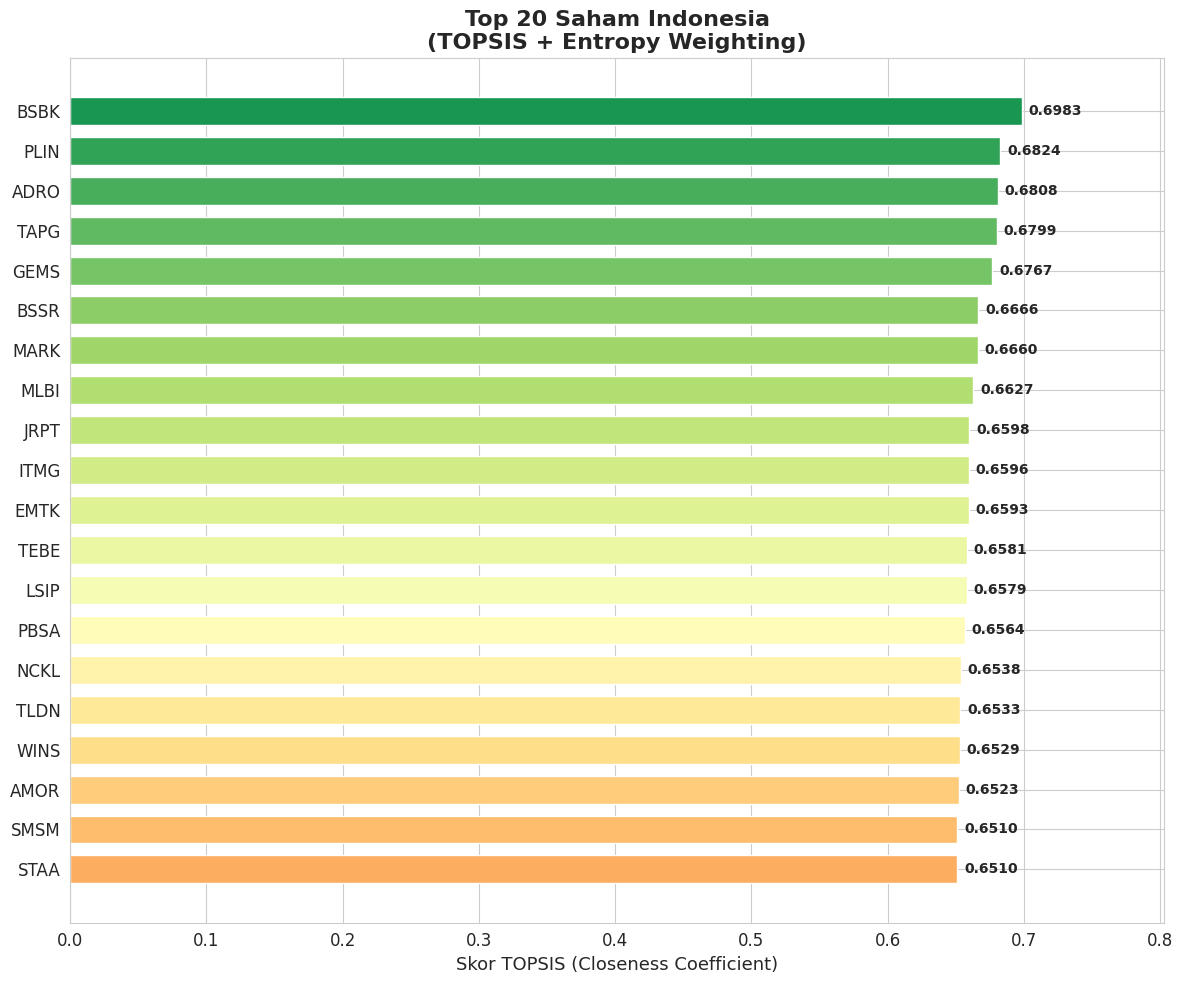

Saved: 03_top20_topsis.png


In [96]:
# 5a. Top 20 Saham — Horizontal Bar Chart

top20 = results.head(20).iloc[::-1]  # reverse untuk bar horizontal

fig, ax = plt.subplots(figsize=(12, 10))

colors_bar = plt.cm.RdYlGn(np.linspace(0.3, 0.9, 20))
bars = ax.barh(top20['Saham'], top20['Skor TOPSIS'], color=colors_bar, edgecolor='white', height=0.7)

for bar, score in zip(bars, top20['Skor TOPSIS']):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
            f'{score:.4f}', va='center', fontweight='bold', fontsize=10)

ax.set_xlabel('Skor TOPSIS (Closeness Coefficient)', fontsize=13)
ax.set_title('Top 20 Saham Indonesia\n(TOPSIS + Entropy Weighting)', fontsize=16, fontweight='bold')
ax.set_xlim(0, top20['Skor TOPSIS'].max() * 1.15)

plt.tight_layout()
plt.savefig('03_top20_topsis.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: 03_top20_topsis.png')

In [97]:
# 5b. Perbandingan: TOPSIS Top 20 vs PE-Only Top 20
# Ini adalah KEY INSIGHT untuk LinkedIn post!

# Top 20 by PE only (termurah)
pe_top20 = results.sort_values('PE Ratio').head(20)
topsis_top20 = results.head(20)

# Hitung overlap
topsis_set = set(topsis_top20['Saham'])
pe_set = set(pe_top20['Saham'])
overlap = topsis_set & pe_set

print(f'PERBANDINGAN METODE')
print(f'=' * 50)
print(f'Overlap Top 20: {len(overlap)} dari 20 saham ({len(overlap)/20*100:.0f}%)')
print(f'\nSaham yang sama di kedua metode: {overlap}')
print(f'\nSaham HANYA di TOPSIS (tidak di PE-only):')
print(f'  {topsis_set - pe_set}')
print(f'\nSaham HANYA di PE-only (tidak di TOPSIS):')
print(f'  {pe_set - topsis_set}')

# Perbandingan kualitas rata-rata
print(f'\nKUALITAS RATA-RATA TOP 20')
print(f'{"": <25s} | {"TOPSIS":>10s} | {"PE-Only":>10s} | {"Winner"}')
print(f'=' * 65)

metrics_compare = [
    ('ROE (%)', 'ROE (%)', 'higher'),
    ('Profit Margin (%)', 'Profit Margin (%)', 'higher'),
    ('D/E Ratio (%)', 'D/E Ratio (%)', 'lower'),
    ('Div Yield (%)', 'Div Yield (%)', 'higher'),
    ('PE Ratio', 'PE Ratio', 'lower'),
    ('PB Ratio', 'PB Ratio', 'lower'),
]

for label, col, direction in metrics_compare:
    t_val = topsis_top20[col].mean()
    p_val = pe_top20[col].mean()
    if direction == 'higher':
        winner = '✅ TOPSIS' if t_val > p_val else '❌ PE-Only'
    else:
        winner = '✅ TOPSIS' if t_val < p_val else '❌ PE-Only'
    print(f'  {label: <25s}| {t_val:>9.2f} | {p_val:>9.2f}  | {winner}')

PERBANDINGAN METODE
Overlap Top 20: 3 dari 20 saham (15%)

Saham yang sama di kedua metode: {'WINS', 'BSBK', 'ITMG'}

Saham HANYA di TOPSIS (tidak di PE-only):
  {'SMSM', 'AMOR', 'ADRO', 'MLBI', 'TEBE', 'MARK', 'GEMS', 'TAPG', 'PBSA', 'EMTK', 'BSSR', 'NCKL', 'LSIP', 'JRPT', 'TLDN', 'PLIN', 'STAA'}

Saham HANYA di PE-only (tidak di TOPSIS):
  {'INKP', 'LPPF', 'MEDC', 'ABMM', 'ISSP', 'ELSA', 'TPMA', 'UNTR', 'GPRA', 'HUMI', 'KKGI', 'TKIM', 'AUTO', 'TUGU', 'GJTL', 'SIMP', 'WOMF'}

KUALITAS RATA-RATA TOP 20
                          |     TOPSIS |    PE-Only | Winner
  ROE (%)                  |     27.29 |     21.64  | ✅ TOPSIS
  Profit Margin (%)        |     32.74 |     19.01  | ✅ TOPSIS
  D/E Ratio (%)            |     10.60 |     62.14  | ✅ TOPSIS
  Div Yield (%)            |      8.00 |      6.74  | ✅ TOPSIS
  PE Ratio                 |      7.16 |      4.24  | ❌ PE-Only
  PB Ratio                 |      2.06 |      0.65  | ❌ PE-Only


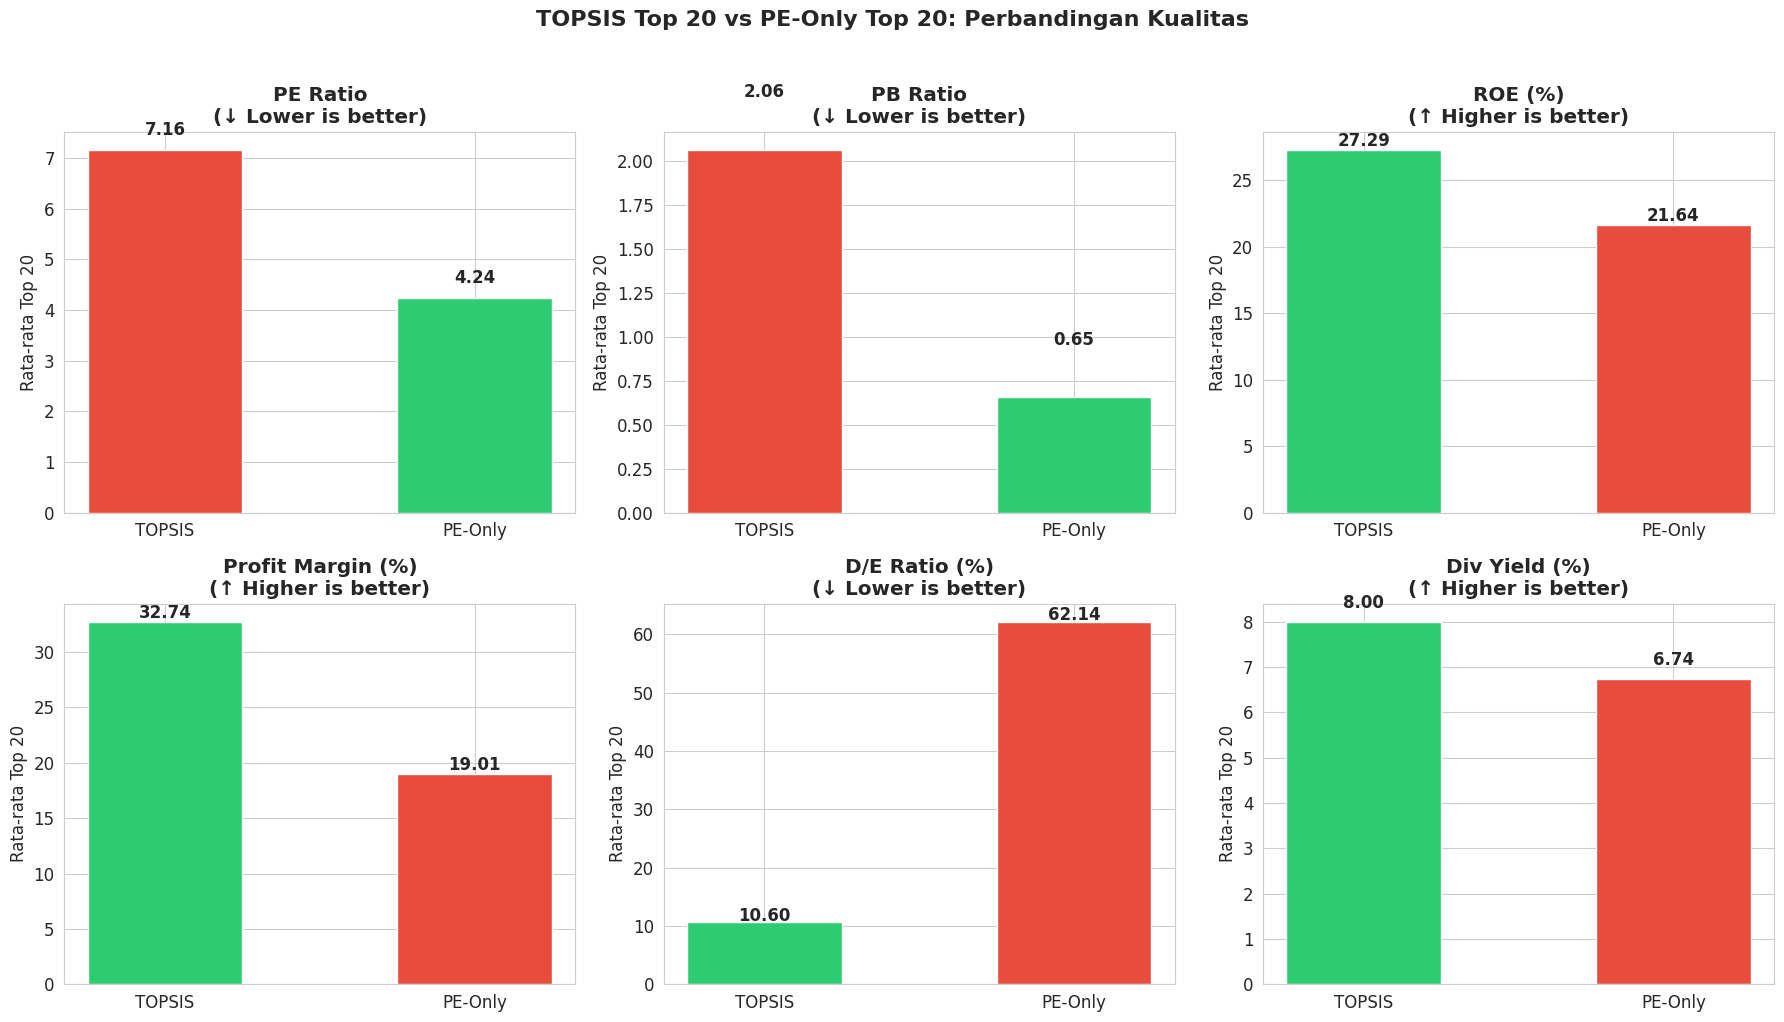

Saved: 04_topsis_vs_pe.png


In [98]:
# 5c. Visualisasi perbandingan TOPSIS vs PE-Only

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('TOPSIS Top 20 vs PE-Only Top 20: Perbandingan Kualitas',
             fontsize=16, fontweight='bold', y=1.02)

compare_cols = ['PE Ratio', 'PB Ratio', 'ROE (%)', 'Profit Margin (%)', 'D/E Ratio (%)', 'Div Yield (%)']
better_dirs = ['lower', 'lower', 'higher', 'higher', 'lower', 'higher']

for ax, col, direction in zip(axes.flat, compare_cols, better_dirs):
    t_val = topsis_top20[col].mean()
    p_val = pe_top20[col].mean()

    # Tentukan warna berdasarkan mana yang lebih baik
    if direction == 'higher':
        t_color = '#2ECC71' if t_val >= p_val else '#E74C3C'
        p_color = '#2ECC71' if p_val > t_val else '#E74C3C'
    else:
        t_color = '#2ECC71' if t_val <= p_val else '#E74C3C'
        p_color = '#2ECC71' if p_val < t_val else '#E74C3C'

    bars = ax.bar(['TOPSIS', 'PE-Only'], [t_val, p_val],
                  color=[t_color, p_color], edgecolor='white', width=0.5)

    for bar, val in zip(bars, [t_val, p_val]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{val:.2f}', ha='center', fontweight='bold', fontsize=12)

    better = '↓ Lower is better' if direction == 'lower' else '↑ Higher is better'
    ax.set_title(f'{col}\n({better})', fontweight='bold')
    ax.set_ylabel('Rata-rata Top 20')

plt.tight_layout()
plt.savefig('04_topsis_vs_pe.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: 04_topsis_vs_pe.png')

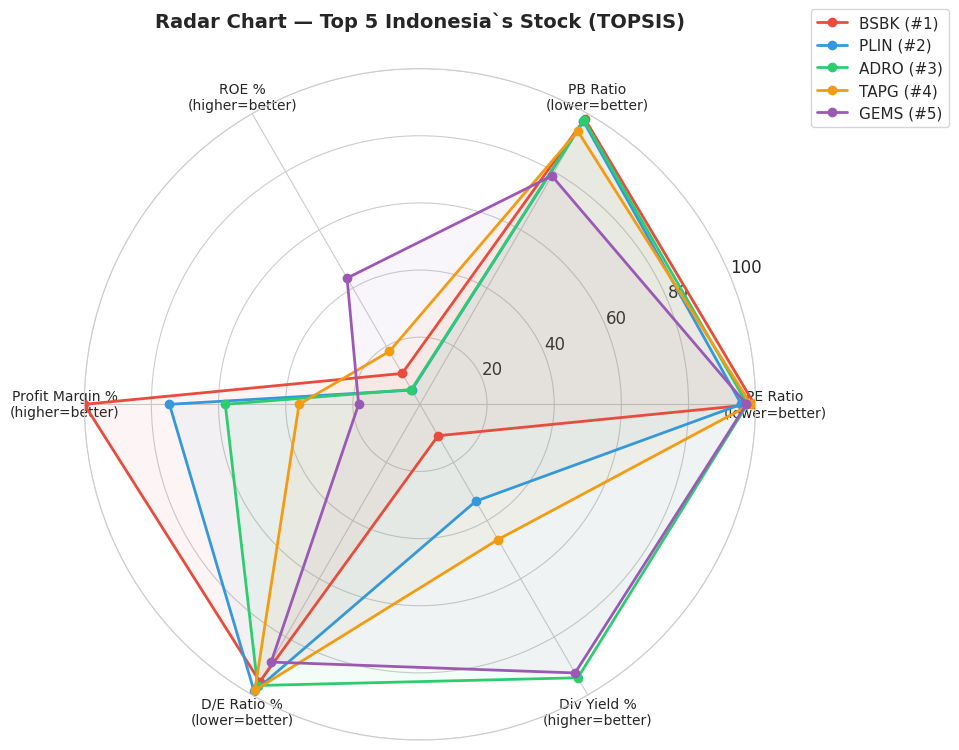

Saved: 05_radar_top5.png


In [99]:
# 5d. Radar Chart — Top 5 Saham

top5 = results.head(5)

# Normalisasi ke 0-100 untuk radar chart
radar_cols = ['PE Ratio', 'PB Ratio', 'ROE (%)', 'Profit Margin (%)', 'D/E Ratio (%)', 'Div Yield (%)']
radar_labels = ['PE Ratio\n(lower=better)', 'PB Ratio\n(lower=better)', 'ROE %\n(higher=better)',
                'Profit Margin %\n(higher=better)', 'D/E Ratio %\n(lower=better)', 'Div Yield %\n(higher=better)']

# Untuk cost criteria, inverse normalisasi (agar lebih besar = lebih baik di radar)
radar_data = pd.DataFrame()
for col, ctype in zip(radar_cols, criteria_types):
    vals = top5[col].values
    all_vals = results[col].values
    if ctype == 'cost':
        # Inverse: nilai kecil jadi skor tinggi
        radar_data[col] = 100 * (1 - (vals - all_vals.min()) / (all_vals.max() - all_vals.min()))
    else:
        radar_data[col] = 100 * (vals - all_vals.min()) / (all_vals.max() - all_vals.min())

# Plot
angles = np.linspace(0, 2 * np.pi, len(radar_cols), endpoint=False).tolist()
angles += angles[:1]  # tutup polygon

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
colors_radar = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12', '#9B59B6']

for i, (_, row) in enumerate(top5.iterrows()):
    values = radar_data.iloc[i].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=f"{row['Saham']} (#{i+1})",
            color=colors_radar[i], markersize=6)
    ax.fill(angles, values, alpha=0.05, color=colors_radar[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_labels, fontsize=10)
ax.set_ylim(0, 100)
ax.set_title('Radar Chart — Top 5 Indonesia`s Stock (TOPSIS)', fontsize=14, fontweight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)

plt.tight_layout()
plt.savefig('05_radar_top5.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: 05_radar_top5.png')

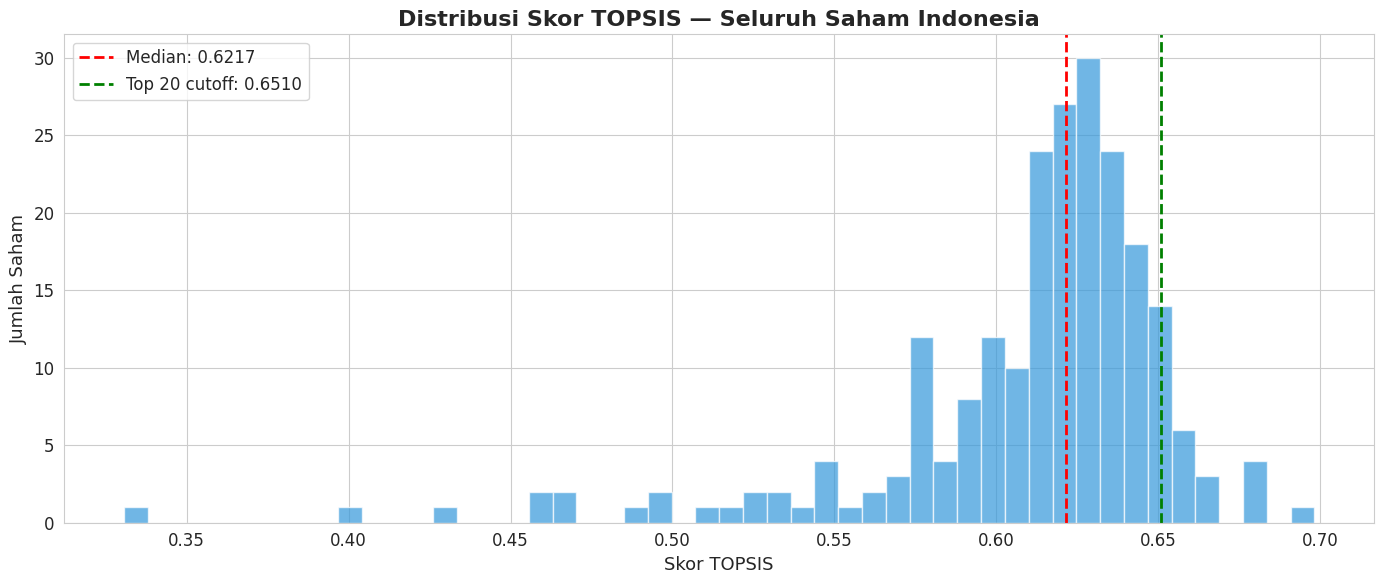

Saved: 06_distribusi_skor.png


In [100]:
# 5e. Distribusi Skor TOPSIS — semua saham

fig, ax = plt.subplots(figsize=(14, 6))

ax.hist(results['Skor TOPSIS'], bins=50, color='#3498DB', alpha=0.7, edgecolor='white')
ax.axvline(results['Skor TOPSIS'].median(), color='red', linestyle='--',
           linewidth=2, label=f'Median: {results["Skor TOPSIS"].median():.4f}')
ax.axvline(results['Skor TOPSIS'].head(20).min(), color='green', linestyle='--',
           linewidth=2, label=f'Top 20 cutoff: {results["Skor TOPSIS"].iloc[19]:.4f}')

ax.set_xlabel('Skor TOPSIS', fontsize=13)
ax.set_ylabel('Jumlah Saham', fontsize=13)
ax.set_title('Distribusi Skor TOPSIS — Seluruh Saham Indonesia', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig('06_distribusi_skor.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: 06_distribusi_skor.png')

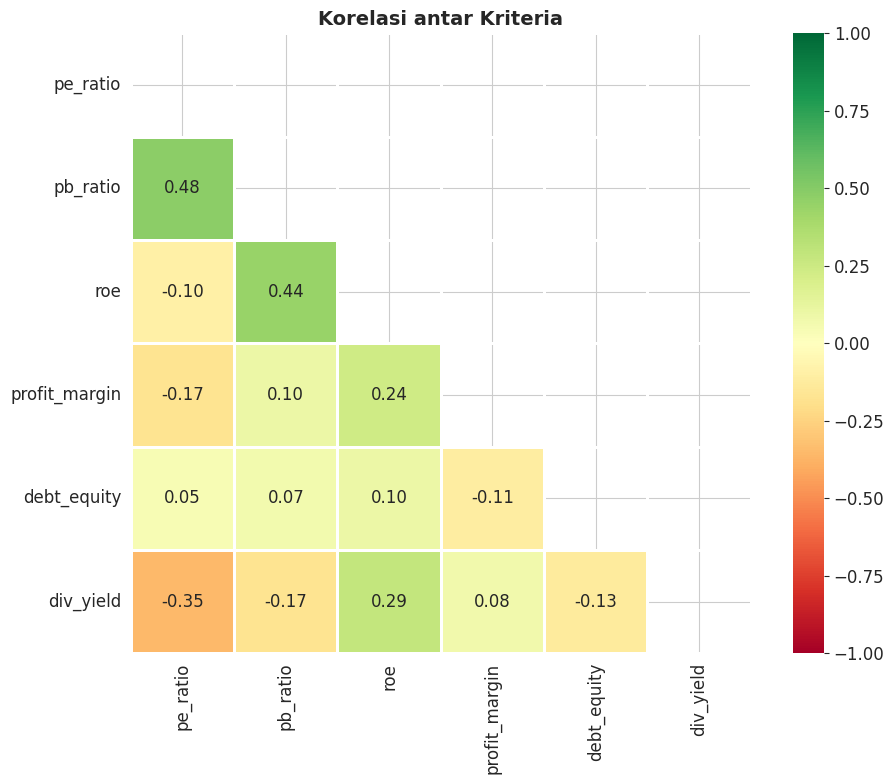

Saved: 07_korelasi.png


In [101]:
# 5f. Heatmap Korelasi antar Kriteria

fig, ax = plt.subplots(figsize=(10, 8))

corr = df_filtered[criteria_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0, square=True, linewidths=1, ax=ax,
            vmin=-1, vmax=1)
ax.set_title('Korelasi antar Kriteria', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('07_korelasi.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: 07_korelasi.png')

---
## Step 6: Ringkasan & Kesimpulan

In [102]:
# 6a. Ringkasan lengkap

print('=' * 70)
print('RINGKASAN ANALISIS TOPSIS + ENTROPY WEIGHTING')
print('   Pemilihan Saham Indonesia')
print('=' * 70)

print(f'\nDATA:')
print(f'   Total saham awal: 956')
print(f'   Saham setelah cleaning: {len(df_filtered)}')
print(f'   Kriteria: {n_criteria}')

print(f'\nBOBOT ENTROPY:')
for col, w, dim in zip(criteria_cols, weights, dimensi):
    print(f'   {col:20s} ({dim:8s}): {w*100:.2f}%')

print(f'\nTOP 10 SAHAM:')
for i, (_, row) in enumerate(results.head(10).iterrows(), 1):
    print(f'   #{i:2d}. {row["Saham"]:6s} | Skor: {row["Skor TOPSIS"]:.4f} | '
          f'PE: {row["PE Ratio"]:6.1f} | ROE: {row["ROE (%)"]:5.1f}% | '
          f'DY: {row["Div Yield (%)"]:5.1f}%')

print(f'\nKEY INSIGHT:')
print(f'   Overlap TOPSIS Top 20 vs PE-Only Top 20: {len(overlap)}/20 ({len(overlap)/20*100:.0f}%)')
print(f'   → {100 - len(overlap)/20*100:.0f}% saham \"murah\" (by PE) BUKAN pilihan terbaik secara holistik!')
print(f'\n   TOPSIS Top 20 vs PE-Only Top 20:')
print(f'   - ROE rata-rata:          {topsis_top20["ROE (%)"].mean():.1f}% vs {pe_top20["ROE (%)"].mean():.1f}%')
print(f'   - Profit Margin rata-rata: {topsis_top20["Profit Margin (%)"].mean():.1f}% vs {pe_top20["Profit Margin (%)"].mean():.1f}%')
print(f'   - D/E rata-rata:          {topsis_top20["D/E Ratio (%)"].mean():.1f}% vs {pe_top20["D/E Ratio (%)"].mean():.1f}%')
print(f'   - Div Yield rata-rata:    {topsis_top20["Div Yield (%)"].mean():.1f}% vs {pe_top20["Div Yield (%)"].mean():.1f}%')

RINGKASAN ANALISIS TOPSIS + ENTROPY WEIGHTING
   Pemilihan Saham Indonesia

DATA:
   Total saham awal: 956
   Saham setelah cleaning: 224
   Kriteria: 6

BOBOT ENTROPY:
   pe_ratio             (Value   ): 14.49%
   pb_ratio             (Value   ): 22.26%
   roe                  (Quality ): 11.85%
   profit_margin        (Quality ): 13.23%
   debt_equity          (Safety  ): 26.27%
   div_yield            (Income  ): 11.89%

TOP 10 SAHAM:
   # 1. BSBK   | Skor: 0.6983 | PE:    3.6 | ROE:  18.4% | DY:   2.0%
   # 2. PLIN   | Skor: 0.6824 | PE:    8.9 | ROE:   8.8% | DY:   6.1%
   # 3. ADRO   | Skor: 0.6808 | PE:    6.5 | ROE:   9.1% | DY:  17.0%
   # 4. TAPG   | Skor: 0.6799 | PE:    5.0 | ROE:  31.0% | DY:   8.4%
   # 5. GEMS   | Skor: 0.6767 | PE:    6.8 | ROE:  73.0% | DY:  16.7%
   # 6. BSSR   | Skor: 0.6666 | PE:    6.0 | ROE:  38.3% | DY:  16.3%
   # 7. MARK   | Skor: 0.6660 | PE:   10.6 | ROE:  30.9% | DY:   8.8%
   # 8. MLBI   | Skor: 0.6627 | PE:   11.4 | ROE:  72.9% | DY:   9.6

In [103]:
# 6b. Export hasil ke Excel

with pd.ExcelWriter('TOPSIS_Saham_Indonesia_Results.xlsx', engine='openpyxl') as writer:

    # Sheet 1: Full ranking
    results.to_excel(writer, sheet_name='Ranking TOPSIS')

    # Sheet 2: Bobot Entropy
    bobot_df = pd.DataFrame({
        'Kriteria': criteria_cols,
        'Dimensi': dimensi,
        'Atribut': criteria_types,
        'Entropy (E)': E,
        'Diversification (d)': d,
        'Bobot (w)': weights,
        'Bobot (%)': weights * 100
    })
    bobot_df.to_excel(writer, sheet_name='Bobot Entropy', index=False)

    # Sheet 3: Solusi Ideal
    ideal_df = pd.DataFrame({
        'Kriteria': criteria_cols,
        'Atribut': criteria_types,
        'A+ (Ideal Best)': A_pos,
        'A- (Ideal Worst)': A_neg
    })
    ideal_df.to_excel(writer, sheet_name='Solusi Ideal', index=False)

    # Sheet 4: Perbandingan
    compare_df = pd.DataFrame({
        'Metrik': ['ROE (%)', 'Profit Margin (%)', 'D/E Ratio (%)', 'Div Yield (%)', 'PE Ratio', 'PB Ratio'],
        'TOPSIS Top 20': [topsis_top20[c].mean() for c in compare_cols],
        'PE-Only Top 20': [pe_top20[c].mean() for c in compare_cols],
        'Better Direction': better_dirs
    })
    compare_df.to_excel(writer, sheet_name='TOPSIS vs PE-Only', index=False)

print('Exported: TOPSIS_Saham_Indonesia_Results.xlsx')
print('Sheets: Ranking TOPSIS, Bobot Entropy, Solusi Ideal, TOPSIS vs PE-Only')

# Download file
files.download('TOPSIS_Saham_Indonesia_Results.xlsx')

Exported: TOPSIS_Saham_Indonesia_Results.xlsx
Sheets: Ranking TOPSIS, Bobot Entropy, Solusi Ideal, TOPSIS vs PE-Only


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
## Catatan

**Disclaimer:** Analisis ini bersifat edukatif dan merupakan portfolio project. Bukan rekomendasi investasi.

**Metode:**
- **Entropy Weighting** menentukan bobot secara objektif berdasarkan variasi data
- **TOPSIS** meranking alternatif berdasarkan kedekatan ke solusi ideal

**Key Takeaway:**
- Memilih saham hanya berdasarkan satu metrik (PE Ratio) menghasilkan pilihan yang berbeda dibanding analisis multi-kriteria
- TOPSIS + Entropy menghasilkan saham dengan kualitas rata-rata lebih tinggi (ROE, Profit Margin, Dividend Yield) dan risiko lebih rendah (D/E Ratio)

**Tools:** Python, Pandas, NumPy, Matplotlib, Seaborn
**Data Source:** Kaggle — Indonesian Stock Market